In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Data Loading
Load the dataset which has been processed by data-cleaning-and-transofrmation.ipynb

In [22]:
# Load the dataset
file_path = './data/processed/marketing_campaign_transformed.csv'
df_transformed = pd.read_csv(file_path, sep=',')

# Correlation Analysis and Feature Selection
Remove Highly Correlated Features with domain knowledge to prevent skew clustering results by giving too much weight to particular features

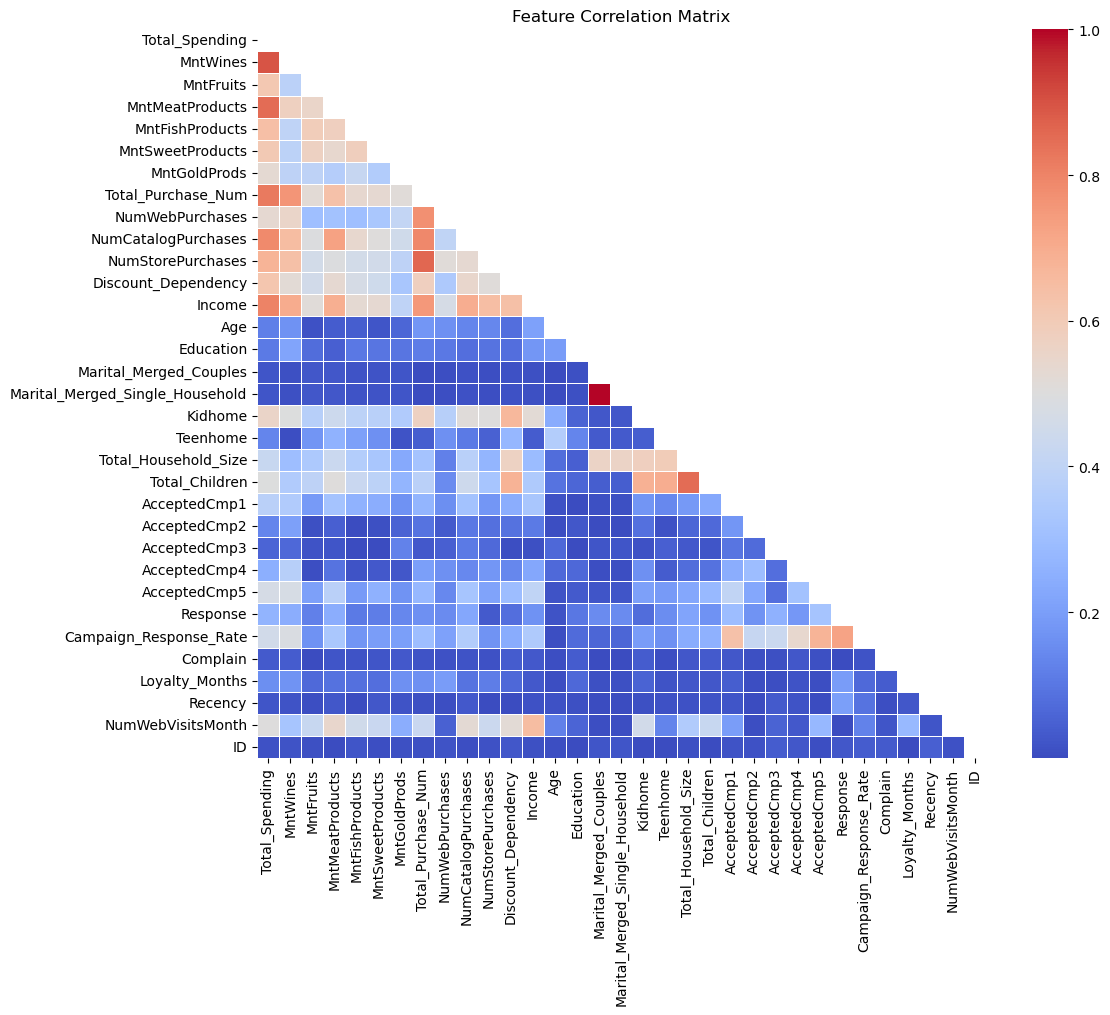

In [23]:
# Calculate correlation matrix 
corr_matrix = df_transformed.corr().abs()

# Visualize correlations
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            annot=False, square=True, linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [24]:
high_corr_features=['MntWines', 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','Kidhome', 'Teenhome','Total_Children','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']

df_filtered = df_transformed.drop(columns=high_corr_features)
print(f"Original shape: {df_transformed.shape}, New shape: {df_filtered.shape}")

Original shape: (2204, 33), New shape: (2204, 15)


# Split the training and testing data set
 - Spilt the training and testing data set before scaling the training data to avoid data leakage

 - Training set: Used to build the clustering model and identify the cluster centers.
 - Test set: Used to:
   - Evaluate how well new data fits into the existing clusters
   - Test the stability of the clusters

In [25]:
# Split before transformation
X_train, X_test = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Before scaling, keep a copy of the ID columns
X_train_ids = X_train['ID'].copy()
X_test_ids = X_test['ID'].copy()

# Remove ID from features used for clustering
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

# Scale/Normalize features for the training data

In [26]:
from sklearn.preprocessing import StandardScaler
# Ensure columns_to_exclude is defined
columns_to_exclude = ['Response','Marital_Merged_Single_Household','Marital_Merged_Couples', 
                       'Marital_Status_Grouped', 'Complain' ]

# Ensure numerical_columns is defined
numerical_columns = X_train.select_dtypes(include=['number']).columns
columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

# Initialize scaler
scaler = StandardScaler()

# Scale numerical features
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

# Print summary of scaled features
print("Scaled Features Summary:")
print(X_train_scaled[columns_to_scale].describe().round(2))

# Verify scaling worked as expected (should see mean ≈ 0 and std ≈ 1)
print("\nVerification of scaling:")
print("Means:", X_train_scaled[columns_to_scale].mean().abs().mean().round(4))
print("Standard deviations:", X_train_scaled[columns_to_scale].std().mean().round(4))

# Save scaled version
X_train_scaled.to_csv('./data/processed/marketing_campaign_scaled.csv', index=False)

Scaled Features Summary:
       Total_Spending  Total_Purchase_Num  Discount_Dependency   Income  \
count         1763.00             1763.00              1763.00  1763.00   
mean             0.00               -0.00                 0.00     0.00   
std              1.00                1.00                 1.00     1.00   
min             -1.02               -1.77                -1.38    -2.37   
25%             -0.91               -0.93                -0.91    -0.77   
50%             -0.34                0.04                -0.21    -0.00   
75%              0.74                0.87                 0.57     0.78   
max              3.18                2.68                 3.37     4.97   

           Age  Education  Total_Household_Size  Campaign_Response_Rate  \
count  1763.00    1763.00               1763.00                 1763.00   
mean     -0.00       0.00                 -0.00                    0.00   
std       1.00       1.00                  1.00                    1.00   

# K-Means Clustering
Key Steps: 
1. Use Elbow Method to find optimal k values
2. Fit the model with optimal k value
3. Evaulate the model with inertia, silhouette_score, and davies_bouldin_score
4. Get Cluster Centroids and Calcualte Relative Variance
6. Evaulate model stability 

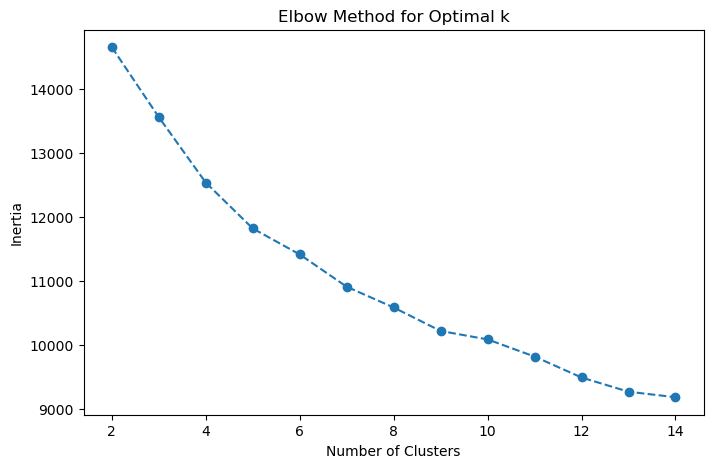

     k       inertia
0    2  14657.219525
1    3  13564.205164
2    4  12541.346811
3    5  11824.486678
4    6  11418.672102
5    7  10913.750456
6    8  10589.167485
7    9  10222.212088
8   10  10090.339208
9   11   9821.980358
10  12   9495.132404
11  13   9272.763598
12  14   9186.756777


In [27]:
# 1. Use Elbow Method to find optimal k values and fit the model
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

res = pd.DataFrame({"k": K_range, "inertia": inertia})
print(res)

In [28]:
#2. Fit the model with optimal k value
from sklearn.metrics import silhouette_score, davies_bouldin_score
BEST_K = 5  

kmeans = KMeans(n_clusters=BEST_K, random_state=42)
kmeans.fit(X_train_scaled)

#3. Evaulate the model with inertia, silhouette_score, and davies_bouldin_score
inertia = kmeans.inertia_
sil_score = silhouette_score(X_train_scaled, kmeans.labels_)
db_score = davies_bouldin_score(X_train_scaled, kmeans.labels_)

print(f"interia: {inertia:.4f}")  # Lower is better
print(f"Silhouette Score: {sil_score:.4f}")  # Higher is better
print(f"Davies-Bouldin Score: {db_score:.4f}")  # Lower is better

interia: 11824.4867
Silhouette Score: 0.1248
Davies-Bouldin Score: 2.2083



Cluster centroids in original scale:
   Total_Spending  Total_Purchase_Num  Discount_Dependency        Income  \
0      963.777448           18.905045             0.163697  60267.011869   
1     1592.601399           19.699301             0.064735  80686.202797   
2      111.980220            6.079121             0.319821  29697.989011   
3      186.591928            7.798206             0.390943  42708.659193   
4     1045.539267           18.264398             0.081745  72201.806283   

         Age  Education  Marital_Merged_Couples  \
0  59.643917   2.789318                0.661721   
1  53.566434   2.608392                0.524476   
2  47.120879   1.837363                0.556044   
3  58.643498   2.876682                0.802691   
4  57.298429   2.424084                0.638743   

   Marital_Merged_Single_Household  Total_Household_Size  \
0                         0.338279              2.531157   
1                         0.475524              1.713287   
2                 

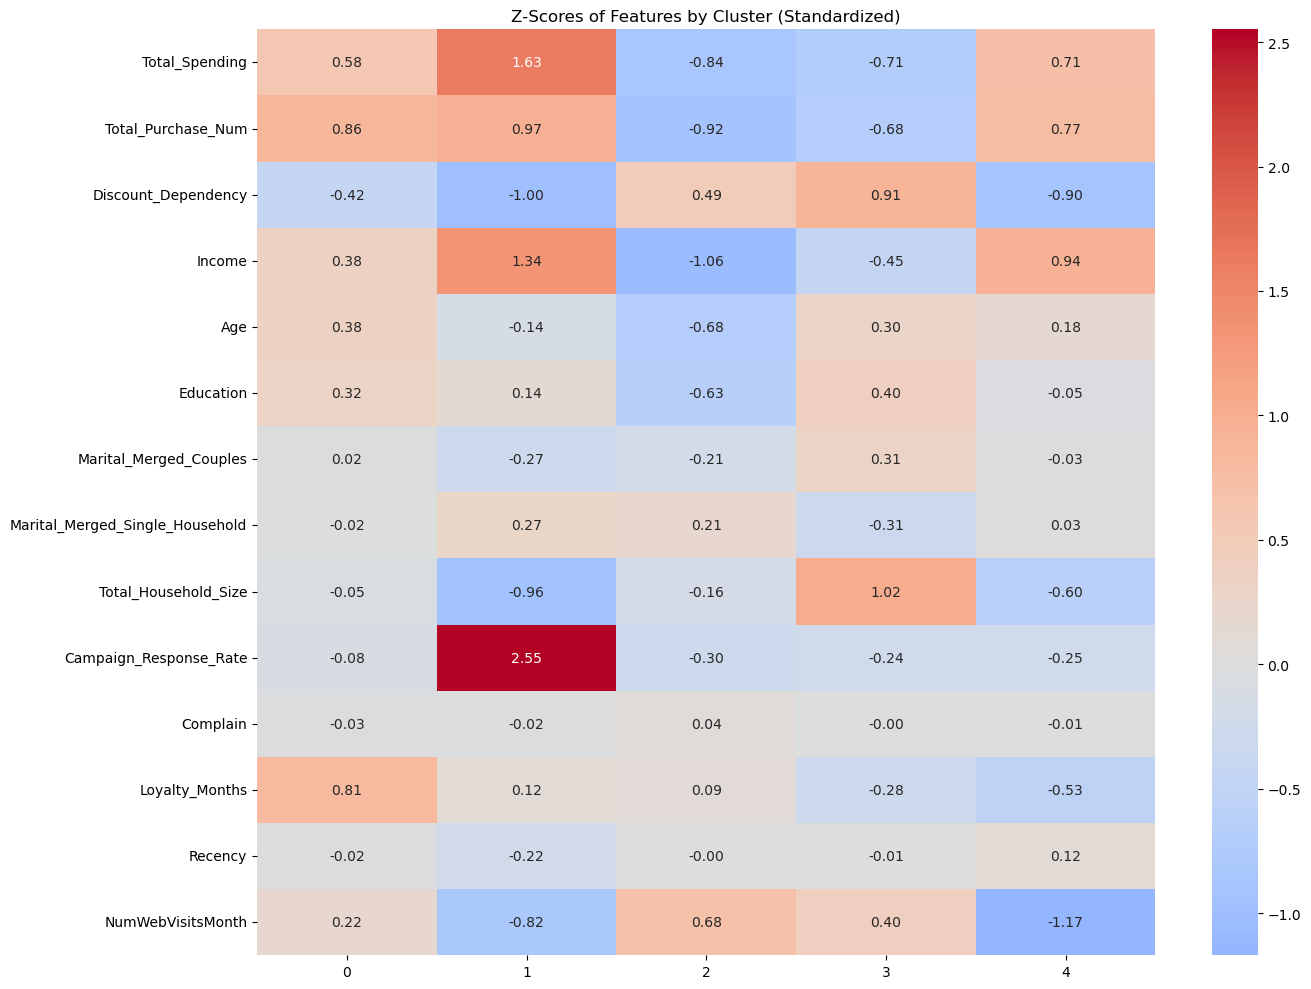

In [29]:
#4. Get Cluster Centroids and Calcualte Relative Variance
centroids_scaled = kmeans.cluster_centers_

# Convert centroids in the original scale
num_features_idx = [X_train_scaled.columns.get_loc(col) for col in columns_to_scale]
centroids_numerical_scaled = centroids_scaled[:, num_features_idx]
centroids_numerical_unscaled = scaler.inverse_transform(centroids_numerical_scaled)
centroids_unscaled = np.copy(centroids_scaled)
centroids_unscaled[:, num_features_idx] = centroids_numerical_unscaled
centroids_df = pd.DataFrame(centroids_unscaled, columns=X_train_scaled.columns)

print("\nCluster centroids in original scale:")
print(centroids_df)
centroids_df.to_csv('./data/output/centroids_original_scale.csv')

# Calculate the overall mean and standard deviation for each feature
overall_mean = X_train.mean()  # Mean of each feature in original data
overall_std = X_train.std()    # Standard deviation of each feature

# Initialize a DataFrame to hold Z-scores of centroids
z_scores_centroids = pd.DataFrame()

# For each feature in the centroids, calculate the Z-score relative to the overall data
for col in centroids_df.columns:
    z_scores_centroids[col] = (centroids_df[col] - overall_mean[col]) / overall_std[col]

# Display the Z-scores for each cluster centroid
print("\nZ-Scores of features in each cluster (relative to overall mean and standard deviation):")
print(z_scores_centroids)

# Visualize the Z-scores as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(z_scores_centroids.T, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Z-Scores of Features by Cluster (Standardized)')
plt.tight_layout()
plt.show()

In [30]:
# Get cluster assignments for both sets
train_clusters = kmeans.labels_
test_clusters = kmeans.predict(X_test_scaled)

X_train_with_result = X_train.copy()
X_train_with_result['Cluster'] = train_clusters
X_test_with_result = X_test.copy()
X_test_with_result['Cluster'] = test_clusters

# Export Cluster Profile 
cluster_profiles = X_train_with_result.groupby('Cluster').mean()
cluster_profiles.to_csv('./data/output/cluster_profiles.csv')

# Merge cluster result with original data
train_results = pd.DataFrame({'ID': X_train_ids, 'Cluster': train_clusters})
test_results = pd.DataFrame({'ID': X_test_ids, 'Cluster': test_clusters})
combined_clusters = pd.concat([train_results, test_results], axis=0)
df_with_clusters = pd.merge(
    df_transformed,
    combined_clusters,
    on='ID',
    how='left'
)
df_with_clusters.to_csv('./data/processed/marketing_campaign_transofrmed_with_clusters.csv', index=False)

#6. Evaulate model stability 
train_dist = X_train_with_result['Cluster'].value_counts(normalize=True)
test_dist = X_test_with_result['Cluster'].value_counts(normalize=True)
print("\nCluster distribution comparison:")
print(pd.DataFrame({'Train': train_dist, 'Test': test_dist}))


Cluster distribution comparison:
            Train      Test
Cluster                    
0        0.191151  0.165533
1        0.081112  0.074830
2        0.258083  0.267574
3        0.252978  0.299320
4        0.216676  0.192744


# Key Features and Insights for each cluster

Through K-means clustering, five distinct customer segments were identified, differentiated by spending patterns, income levels, discount dependency, household size, campaign responsiveness, and web engagement. The following sections detail each segment’s key features, distribution (proportion in train and test datasets), insights, and actionable business takeaways.

#### **Cluster 3: Discount-Driven Family Shoppers**
**Key Features:** Low spending ($187), low purchase frequency (7.80), high discount dependency (0.39), moderate income ($42,709), largest households (3.50), low campaign response (4.0%), low complaints (0.009), high web visits (6.26).

**Distribution:** Train: 25.30%, Test: 29.93%. (most common).

**Insight:** The largest cluster, these price-sensitive customers rely heavily on discounts and have bigger households, driving lower per-person spending. High web visits reflect active deal-seeking behavior.

**Business Takeaway**: Prioritize frequent online promotions and family-oriented deals to retain this dominant segment. Leverage their high web activity with targeted online promotions.

#### **Cluster 2: Budget-Conscious Low Sepdners**
**Key Features:** Very low spending ($112), low purchase frequency (6.08), high discount dependency (0.32), low income ($29,698), moderate household size (2.44), very low campaign response (3.2%), higher complaints (0.013), high web visits (6.93).

**Distribution:** Train: 25.81%, Test: 26.76% (2nd most common).

**Insight:** This large group spends the least, constrained by low income and reliant on discounts. Frequent web visits suggest they’re hunting for value, while slightly higher complaints indicate some dissatisfaction.

**Business Takeaway**: Offer low-cost products and aggressive online discounts, addressing complaints to improve retention.

#### **Cluster 4: Stable Middle-Income Spenders**
**Key Features:** High spending ($1,046), moderate purchase frequency (18.26), low discount dependency (0.08), high income ($72,202), smaller households (2.04), low campaign response (4.0%), low complaints (0.008), low web visits (2.49).

**Distribution:** Train: 21.67%, Test: 19.27% (3rd most common).

**Insight:** This segment spends steadily with high income and minimal reliance on discounts or campaigns, suggesting they value quality or habit over deals. Their low web activity indicates a preference for traditional shopping channels (e.g., in-store).

**Business Takeaway:** Maintain their loyalty with consistent, quality-focused offerings through offline channels.

#### **Cluster 0: Engaged Middle-Income Spenders**
**Key Features:** High spending ($964), high purchase frequency (18.91), moderate discount dependency (0.16), solid income ($60,267), moderate household size (2.53), low campaign response (6.4%), very low complaints (0.006), moderate web visits (5.82).

**Distribution:** Train: 19.12%, Test: 16.55%. (4th most common).

**Insight:** These customers are active spenders with a slightly higher responsiveness to campaigns compared to Cluster 0. They’re middle-income with moderate online engagement. Their discount dependency is low-to-moderate, suggesting they’re selective but not entirely price-driven.

**Business Takeaway:** Target this group with tailored campaigns (since they’ve shown some responsiveness) and enhance their online experience to boost web purchases, given their moderate web activity.

#### **Cluster 1: Affluent High-Spending Responders**
**Key Features:** Very high spending ($1,593), high purchase frequency (19.70), low discount dependency (0.06), highest income ($80,686), smallest households (1.71), very high campaign response (45.9%), low complaints (0.007), low web visits (3.34).

**Distribution:** Train: 8.11%, Test: 7.48% (least common).

**Insight:** The smallest cluster, these affluent customers spend heavily, respond strongly to campaigns, and don’t rely on discounts. Small households and low web visits point to a focus on quality and offline shopping.

**Business Takeaway:** Invest heavily in personalized campaigns (e.g., exclusive offers, loyalty rewards) for this group, as they’re highly responsive and profitable. Focus on offline channels like catalogs or in-store experiences.

# General Observations

- **Uniform Features Across Clusters:**
    - Age: Ranges narrowly from 47 to 60, averaging around 53–59 for most clusters mean, indicating a mature customer base with little age-driven variation.
    - Education: Varies from 1.84 to 2.88, but most clusters hover around 2.4–2.8, suggesting a moderate-to-high education level with minor differentiation.
    - Recency: Consistently 47–50 days across all clusters, showing similar purchase timing and no significant recency-based segmentation.
    - Loyalty (Months): Ranges from  138 to 147, averaging 139–143 for most, reflecting a highly loyal customer base with little variation.
    - Implication: These features don’t strongly influence cluster separation, suggesting a demographically stable, loyal population where behavior (spending, discounts, campaigns) drives differences.
- **Spending vs. Income:** Spending aligns closely with income levels—Cluster 1 (highest income) spends the most, while Cluster 2 (lowest income) spends the least. This suggests income is a key driver of purchasing power.
- **Discount Dependency:** Lower-income clusters (2 and 3) rely heavily on discounts, while higher-income clusters (0, 1, 4) are less price-sensitive, offering opportunities for differentiated pricing strategies.
- **Campaign Responsiveness:** Cluster 1 stands out as highly responsive to campaigns, while others show low engagement. This highlights the potential for targeted marketing to unlock value in specific segments.

# Business Applications Conclusion
- **Product Customization:** Develop premium products for Cluster 1 and affordable, discount-friendly options for Clusters 2 and 3.
- **Marketing Strategy:** Allocate campaign budgets toward Cluster 1 for maximum ROI, while using frequent online promotions for Clusters 2 and 3. Clusters 0 and 4 may benefit from loyalty programs over aggressive marketing.
- **Channel Optimization:** Enhance the website for deal-hunters (Clusters 2 and 3) and invest in catalog/in-store experiences for Cluster 4.
- **Customer Retention:** Address Cluster 2’s slightly higher complaint rate to prevent churn, and reward Cluster 1’s responsiveness with exclusive perks.